In [1]:
#Paquetes para modelos
import sciann as sn
import numpy as np
from sciann.utils.math import diff, sign, sin, exp
from sciann.utils import math as scmath

#Paquetes para gráficos

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

---------------------- SCIANN 0.5.5.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



# Ecuación de la Barra

#### Variables del Modelo


In [2]:
x = sn.Variable('x')
t = sn.Variable('t')
u = sn.Functional("u", [x,t], 5*[5] ,"tanh")

In [3]:
#Función de activación para los bordes

def activacion(coord,location,direction):
    return (1-sign(direction*(location-coord)))/2

#### Constantes

In [4]:
TOL = 0.05 # Esta constante se usa para que los bordes tomen valores y se activen las funciones de contorno
conveccion = 25. # Coeficiente de pérdida de calor en los bordes y=1 e y=-1
conductividad = .1 # Capacidad conductora de calor del material de la placa
capCal = 1. # Capacidad de retención de calor del material de la placa
focoTemp = 25. # Temperatura del foco de calor
tempExt = 5. # Temperatura del exterior
tempInicial = 0. # Temperatura inicial de la placa

#### Mallado

In [5]:
denspt = 25 # Densidad de puntos de evaluación de los funcionales
xmin,xmax=-1,1 # Límites en x e y
tmin,tmax=0,10 # Límites en tiempo t
xrange=xmax-xmin
trange=tmax-tmin

# Mallado (es una malla en tres dimensiones)
x_data, t_data = np.meshgrid(
    np.linspace(xmin, xmax, xrange*denspt),
    np.linspace(tmin,tmax,trange*denspt)
)

x_data = x_data.flatten()[:,None]
t_data = t_data.flatten()[:,None]

x_data.shape

(12500, 1)

#### Ecuaciones del calor y del borde izquierdo

In [6]:
#Este funcional explica el flujo del calor a lo largo de la placa (2 dimensiones)
L1 = sn.constraints.PDE(capCal*diff(u,t) - conductividad *( (diff(u,x,order=2) )))

In [7]:
LI = sn.constraints.PDE((activacion(x,-1+TOL,-1)*conductividad*(- diff(u,x))))

#### Datos introducidos como puntos

In [8]:
#TInicial
indInicial = np.where(t_data<TOL)[0]
calorInicial = np.full(len(indInicial),-2.)

#Elegimos x > 1-TOL y t>TOL
indDerecha = np.where(x_data>1-TOL)[0]
indT_No_Inicial = np.where(t_data>TOL)[0]
indDerecha = np.intersect1d(indDerecha,indT_No_Inicial)
calorDerecha = np.full(len(indDerecha),tempExt)

#Foco de calor
indFoco = np.where(np.abs(x_data)<0.2)[0]
indT_desde_20 = np.where(t_data>2)[0]
indFoco = np.intersect1d(indFoco,indT_desde_20)
calorFoco = focoTemp * np.exp(-(x_data[indFoco,0]**2)/(2*(0.3)**2))/(2*np.pi*0.3)

#Unimos todos los datos
indices = np.concatenate((indInicial,indDerecha,indFoco))[:,None]
datos = np.concatenate((calorInicial,calorDerecha,calorFoco))[:,None]

d1 = sn.constraints.Data(u)

#### Gráfica de los puntos introducidos

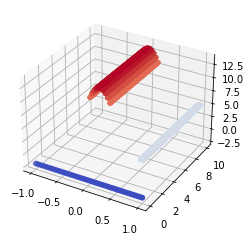

In [9]:
fig=plt.figure()
ax = fig.gca(projection='3d')

X=x_data[indices,0]
Y=t_data[indices,0]
Z=datos

ax.scatter3D(X,Y,Z,c=datos,cmap=cm.coolwarm)

# Construcción del modelo

In [10]:
m = sn.SciModel ([x,t], [d1,L1,LI],"mse","Adam")

## Entrenamiento

In [11]:
history = m.train([x_data,  t_data], [(indices,datos)]+2*['zeros'], epochs =2000,verbose=0,stop_loss_value=0.01,
                  batch_size=16000)

In [12]:
print((history.history['loss'][0:10],history.history['loss'][-1]))

([119.85651397705078, 119.33934783935547, 118.82555389404297, 118.31555938720703, 117.80978393554688, 117.30841827392578, 116.81155395507812, 116.31916809082031, 115.83140563964844, 115.34842681884766], 6.579285144805908)


# Gráficos del modelo resultante

In [17]:
denspt = 25 # Densidad de puntos de evaluación de los funcionales
xmin,xmax=-1,1 # Límites en x e y
tmin,tmax=0,10 # Límites en tiempo t
xrange=xmax-xmin
trange=tmax-tmin

x_test, t_test = np.meshgrid(
    np.linspace(xmin, xmax, xrange*denspt), 
    np.linspace(tmin, tmax, trange*denspt)
)
u_pred =  u.eval(m, [x_test, t_test])
# u_pred = u.eval(m,[x_test,t_test])
# u_diferencia = np.absolute(u_pred-u_base_pred)

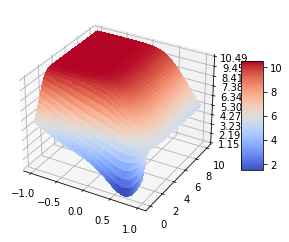

In [18]:
fig=plt.figure()
ax = fig.gca(projection='3d')

X = x_test
Y = t_test
Z = u_pred


surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False )

# Customize the z axis.
ax.set_zlim(u_pred.min(), u_pred.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

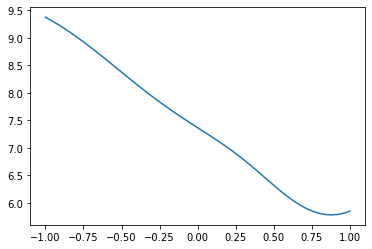

In [31]:
#Índices del punto a mostrar
t_cell = 1.45*25

t_cell = int(np.round(t_cell))

plt.plot(x_test[t_cell],u_pred[t_cell])